# Currency Market Predictor - Deep Regressor

Predicting BTCUSD market

In [1]:
import tensorflow as tf
from tensorflow.contrib import rnn
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Read data

In [2]:
dataset = pd.read_csv('data/coinbaseUSD_1-min_data_2014-12-01_to_2017-10-20.csv')
dataset.head(20)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,1417412040,300.0,300.0,300.0,300.0,0.01,3.0,300.0
2,1417412100,300.0,300.0,300.0,300.0,0.01,3.0,300.0
3,1417412160,300.0,300.0,300.0,300.0,0.01,3.0,300.0
4,1417412220,300.0,300.0,300.0,300.0,0.01,3.0,300.0
5,1417412280,300.0,300.0,300.0,300.0,0.01,3.0,300.0
6,1417412340,300.0,300.0,300.0,300.0,0.01,3.0,300.0
7,1417412400,300.0,300.0,300.0,300.0,0.01,3.0,300.0
8,1417412460,300.0,300.0,300.0,300.0,0.01,3.0,300.0
9,1417412520,300.0,300.0,300.0,300.0,0.01,3.0,300.0


In [3]:
dataset.tail(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
1459066,1508457060,5705.25,5705.25,5705.24,5705.25,2.645729,15094.527857,5705.243162
1459067,1508457120,5705.01,5705.01,5705.01,5705.01,2.239995,12779.191992,5705.010000
1459068,1508457180,5705.01,5705.01,5701.01,5701.01,1.906660,10877.267534,5704.881021
1459069,1508457240,5703.22,5703.22,5700.00,5700.00,4.793786,27325.020313,5700.091678
1459070,1508457300,5700.01,5700.01,5700.00,5700.00,1.492222,8505.677349,5700.009268
1459071,1508457360,5700.01,5700.01,5700.00,5700.01,4.107598,23413.350886,5700.009878
1459072,1508457420,5700.01,5700.54,5700.01,5700.54,3.377075,19250.702466,5700.407366
1459073,1508457480,5700.54,5704.01,5700.53,5704.01,5.572255,31770.431877,5701.539951
1459074,1508457540,5703.96,5704.01,5702.87,5704.01,2.489754,14200.042922,5703.392752
1459075,1508457600,5704.00,5704.01,5704.00,5704.01,1.700455,9699.411610,5704.009412


In [112]:
# Make the neural net happy with the inputs: zero mean, -1 to 1
# only about 0.1% of high jumps in volume are clipped.

dataset['Weighted_Price_PCT'] = dataset['Weighted_Price'].pct_change().fillna(0)
dataset['Weighted_Price_PCT'] = dataset['Weighted_Price_PCT']*2
dataset['Weighted_Price_PCT'] = dataset['Weighted_Price_PCT'].clip(-1,1)

dataset['Weighted_Price_PCT_hour'] = dataset['Weighted_Price'].pct_change(periods=10).fillna(0)
dataset['Weighted_Price_PCT_hour'] = dataset['Weighted_Price_PCT_hour']*2
dataset['Weighted_Price_PCT_hour'] = dataset['Weighted_Price_PCT_hour'].clip(-1,1)

dataset['Volume_(BTC)_PCT'] = dataset['Volume_(BTC)'].pct_change().fillna(0)
dataset['Volume_(BTC)_PCT'] = dataset['Volume_(BTC)_PCT'] + 1
dataset['Volume_(BTC)_PCT'] = np.clip(np.log(dataset['Volume_(BTC)_PCT'])/10, -1,1)

In [66]:
dataset.tail(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Weighted_Price_PCT,Weighted_Price_PCT_hour,Volume_(BTC)_PCT
1459066,1508457060,5705.25,5705.25,5705.24,5705.25,2.645729,15094.527857,5705.243162,-2.360177e-06,-1.609397e-07,0.003618
1459067,1508457120,5705.01,5705.01,5705.01,5705.01,2.239995,12779.191992,5705.010000,-8.173611e-05,-8.409619e-05,-0.016647
1459068,1508457180,5705.01,5705.01,5701.01,5701.01,1.906660,10877.267534,5704.881021,-4.521619e-05,-1.269505e-04,-0.016112
1459069,1508457240,5703.22,5703.22,5700.00,5700.00,4.793786,27325.020313,5700.091678,-1.679033e-03,-1.724211e-03,0.092197
1459070,1508457300,5700.01,5700.01,5700.00,5700.00,1.492222,8505.677349,5700.009268,-2.891539e-05,-1.707924e-03,-0.116705
1459071,1508457360,5700.01,5700.01,5700.00,5700.01,4.107598,23413.350886,5700.009878,2.141400e-07,-2.870126e-05,0.101257
1459072,1508457420,5700.01,5700.54,5700.01,5700.54,3.377075,19250.702466,5700.407366,1.394693e-04,1.396834e-04,-0.019583
1459073,1508457480,5700.54,5704.01,5700.53,5704.01,5.572255,31770.431877,5701.539951,3.973697e-04,5.368667e-04,0.050079
1459074,1508457540,5703.96,5704.01,5702.87,5704.01,2.489754,14200.042922,5703.392752,6.499301e-04,1.047429e-03,-0.080562
1459075,1508457600,5704.00,5704.01,5704.00,5704.01,1.700455,9699.411610,5704.009412,2.162431e-04,8.662434e-04,-0.038129


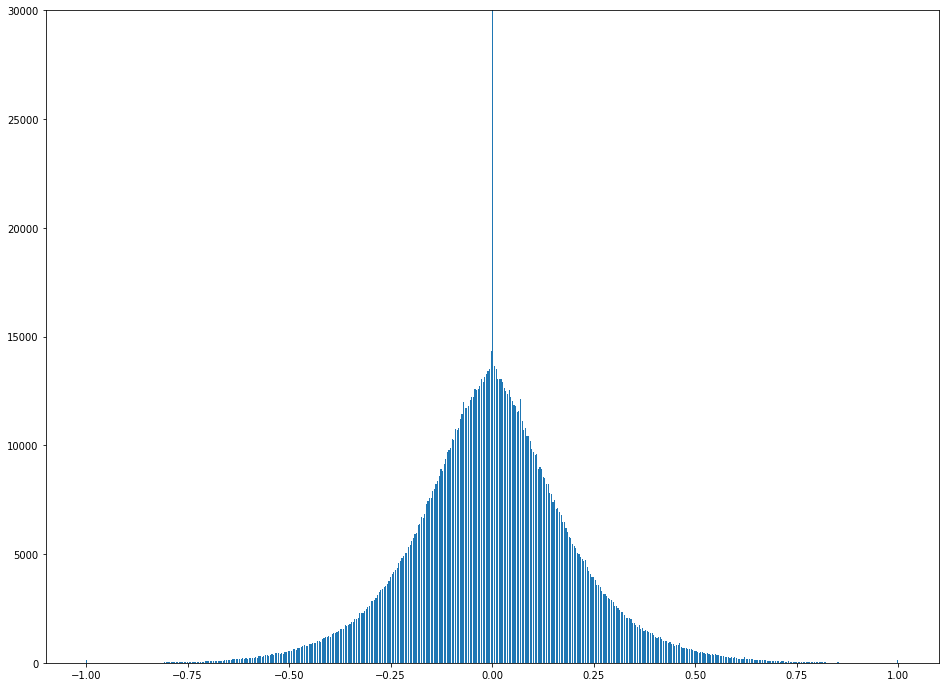

In [67]:
# Make sure the BTC Volume has nice NN properties

plt.figure(figsize=(16,12))

hist, bins = np.histogram(dataset['Volume_(BTC)_PCT'], bins=500)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
#plt.xlim(0, 10)
plt.ylim(0, 30000)
plt.show()

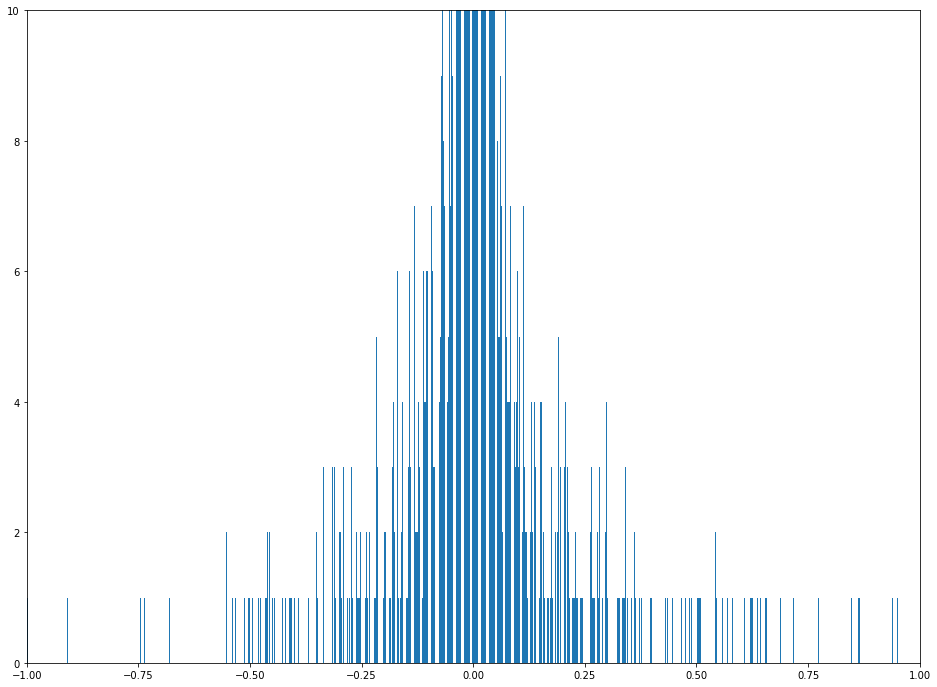

In [68]:

plt.figure(figsize=(16,12))


hist, bins = np.histogram(dataset['Weighted_Price_PCT'], bins=1000)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.xlim(-1, 1)
plt.ylim(0, 10)
plt.show()

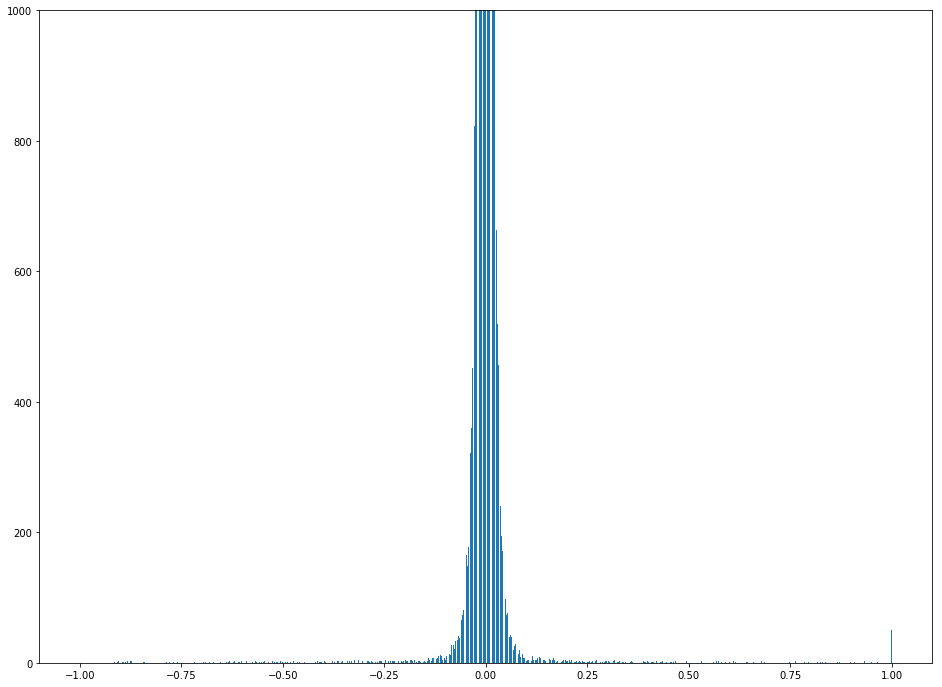

In [69]:
plt.figure(figsize=(16,12))


hist, bins = np.histogram(np.clip(dataset['Weighted_Price_PCT_hour']*2,-1,1), bins=1000)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
#plt.xlim(-1, 1)
plt.ylim(0, 1000)
plt.show()

In [70]:
input_data = dataset[['Weighted_Price_PCT','Volume_(BTC)_PCT']].iloc[-500000:]
target_data = dataset['Weighted_Price_PCT_hour'].iloc[-500000:]

# split data into test and validation data
prediction_mins = 18000 # 5 days 
training_input = input_data[:len(input_data)-prediction_mins]
validation_input = input_data[len(input_data)-prediction_mins:]

training_target = target_data[:len(target_data)-prediction_mins]
validation_target = target_data[len(target_data)-prediction_mins:]




In [86]:

X_train = training_input[0:len(training_input)-5]
Y_train = training_target[5:len(training_target)]

X_train = np.expand_dims(X_train, axis=1)

In [87]:
print(X_train.shape)
print(Y_train.shape)

(481995, 1, 2)
(481995,)


In [92]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, GRU
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=2)

# Initialising the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(GRU(256, return_sequences=True, dropout=0.2, input_shape = (None, 2)))

# Adding the input layer and the LSTM layer
regressor.add(GRU(units = 256, dropout=0.2, input_shape = (None, 256)))

# Adding the output layer
regressor.add(Dense(units = 32))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, Y_train, batch_size = 2048, epochs = 10, validation_split=0.2, callbacks=[early_stopping])

Train on 385596 samples, validate on 96399 samples
Epoch 1/10
385596/385596 [==============================] - 36s 93us/step - loss: 2.0897e-05 - val_loss: 1.2103e-05
Epoch 2/10
385596/385596 [==============================] - 34s 88us/step - loss: 1.6637e-05 - val_loss: 1.2023e-05
Epoch 3/10
385596/385596 [==============================] - 34s 87us/step - loss: 1.6624e-05 - val_loss: 1.2016e-05
Epoch 4/10
385596/385596 [==============================] - 32s 84us/step - loss: 1.6631e-05 - val_loss: 1.2210e-05
Epoch 5/10
385596/385596 [==============================] - 32s 84us/step - loss: 1.6669e-05 - val_loss: 1.1999e-05
Epoch 6/10
385596/385596 [==============================] - 35s 91us/step - loss: 1.6619e-05 - val_loss: 1.1991e-05
Epoch 7/10
385596/385596 [==============================] - 33s 85us/step - loss: 1.6701e-05 - val_loss: 1.2038e-05
Epoch 8/10
385596/385596 [==============================] - 32s 84us/step - loss: 1.6654e-05 - val_loss: 1.2030e-05


In [93]:
# Making the predictions
test_set = validation_input[0:len(test_set)-2]
test_set = np.expand_dims(test_set, axis=1)
#inputs = np.reshape(test_set, (len(test_set), 1, 1))
predicted_BTC_price = regressor.predict(test_set)


In [104]:
test_set.shape

(17996, 1, 2)

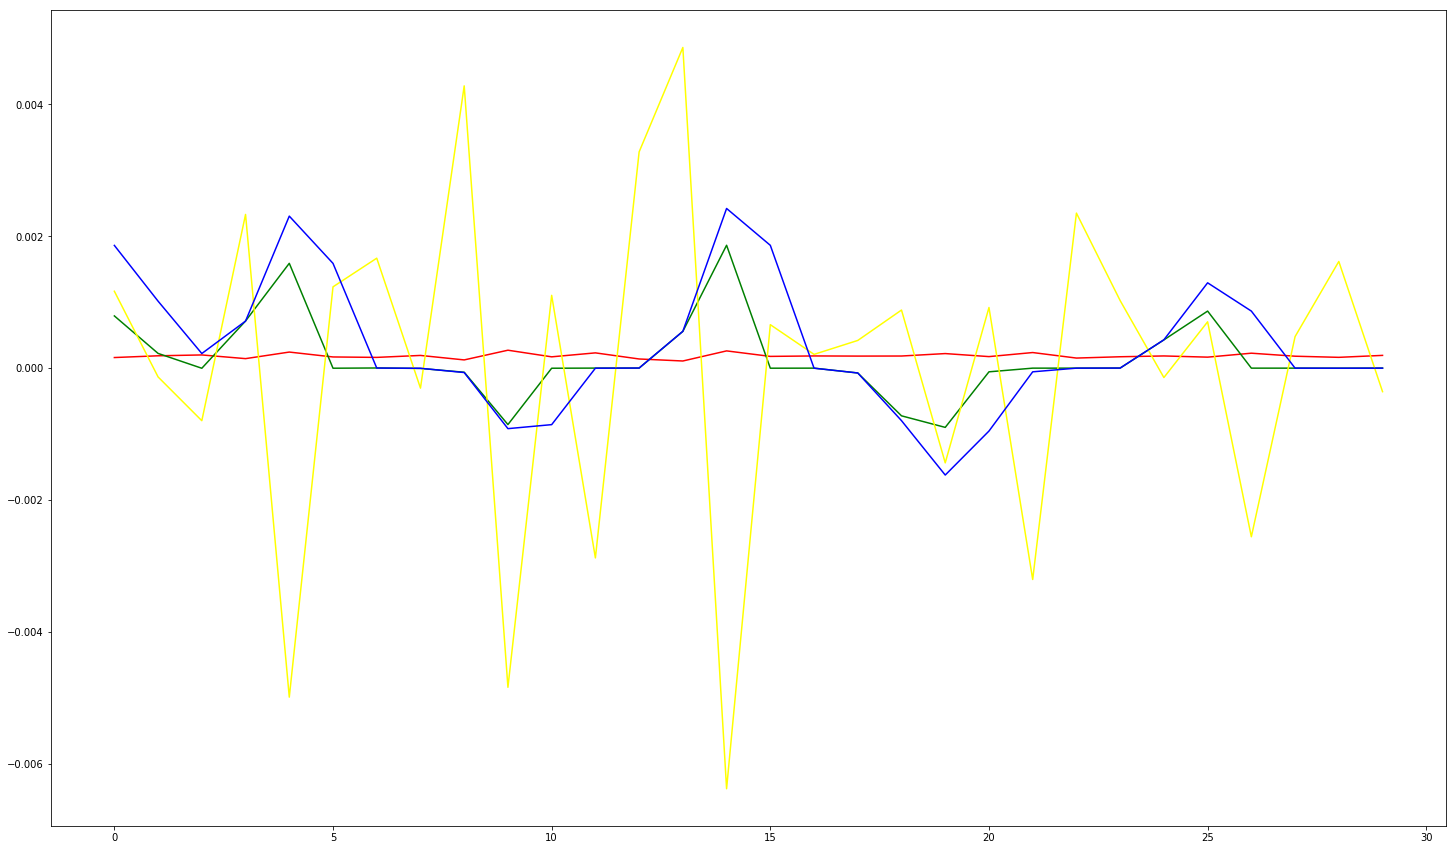

In [111]:
plt.figure(figsize=(25,15))
plt.plot(predicted_BTC_price[270:300], color = 'red')
plt.plot(test_set[270:300,0,0], color = 'green')
plt.plot(test_set[270:300,0,1]/50, color = 'yellow')
plt.plot(validation_target.values[270:300], color = 'blue')

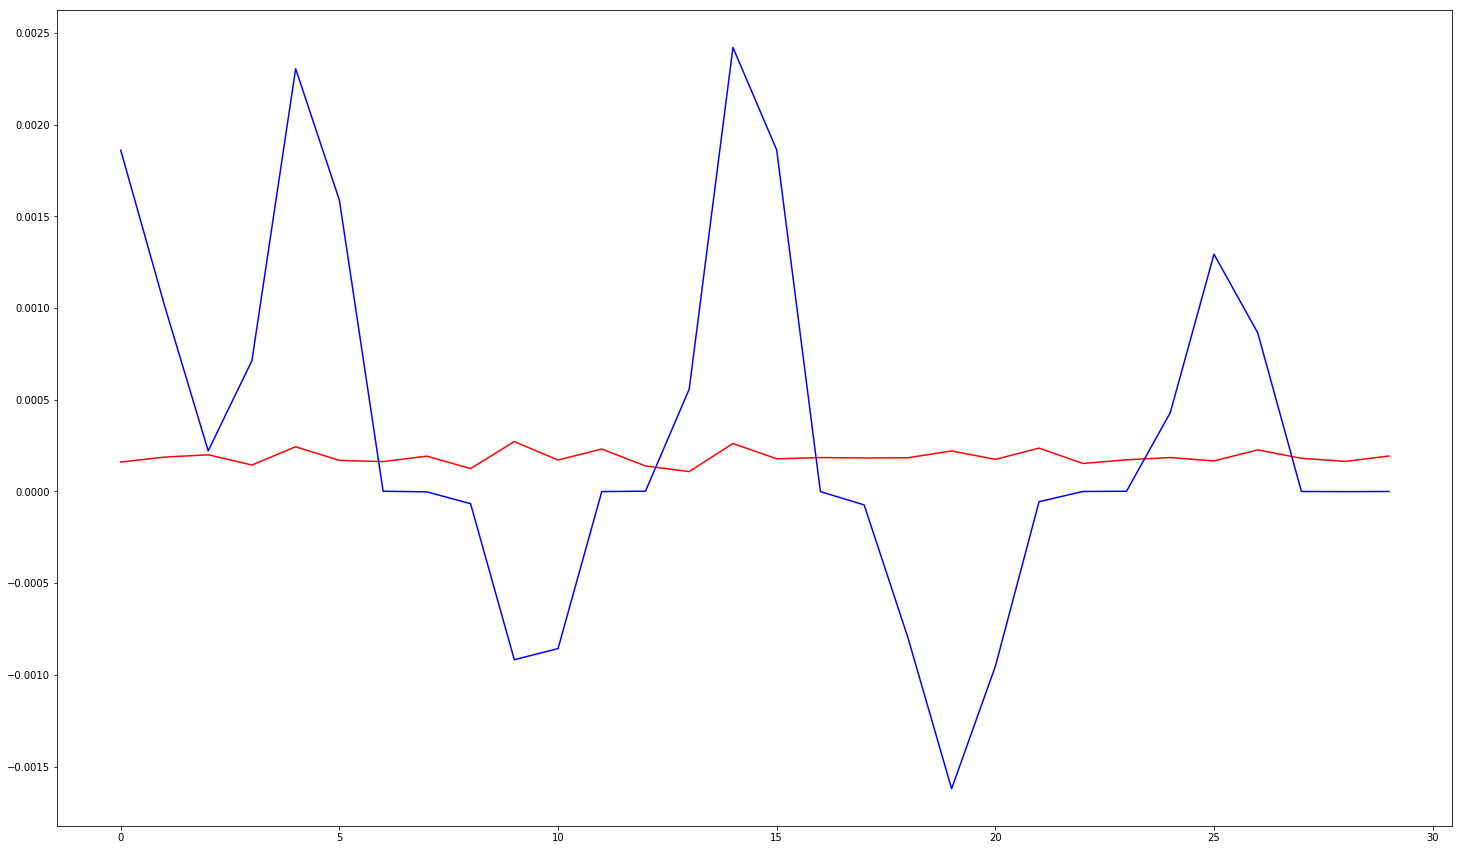

In [98]:
plt.figure(figsize=(25,15))
plt.plot(predicted_BTC_price[270:300], color = 'red')

plt.plot(validation_target.values[270:300], color = 'blue')

ValueError: x and y can be no greater than 2-D, but have shapes (17996,) and (17996, 1, 2)

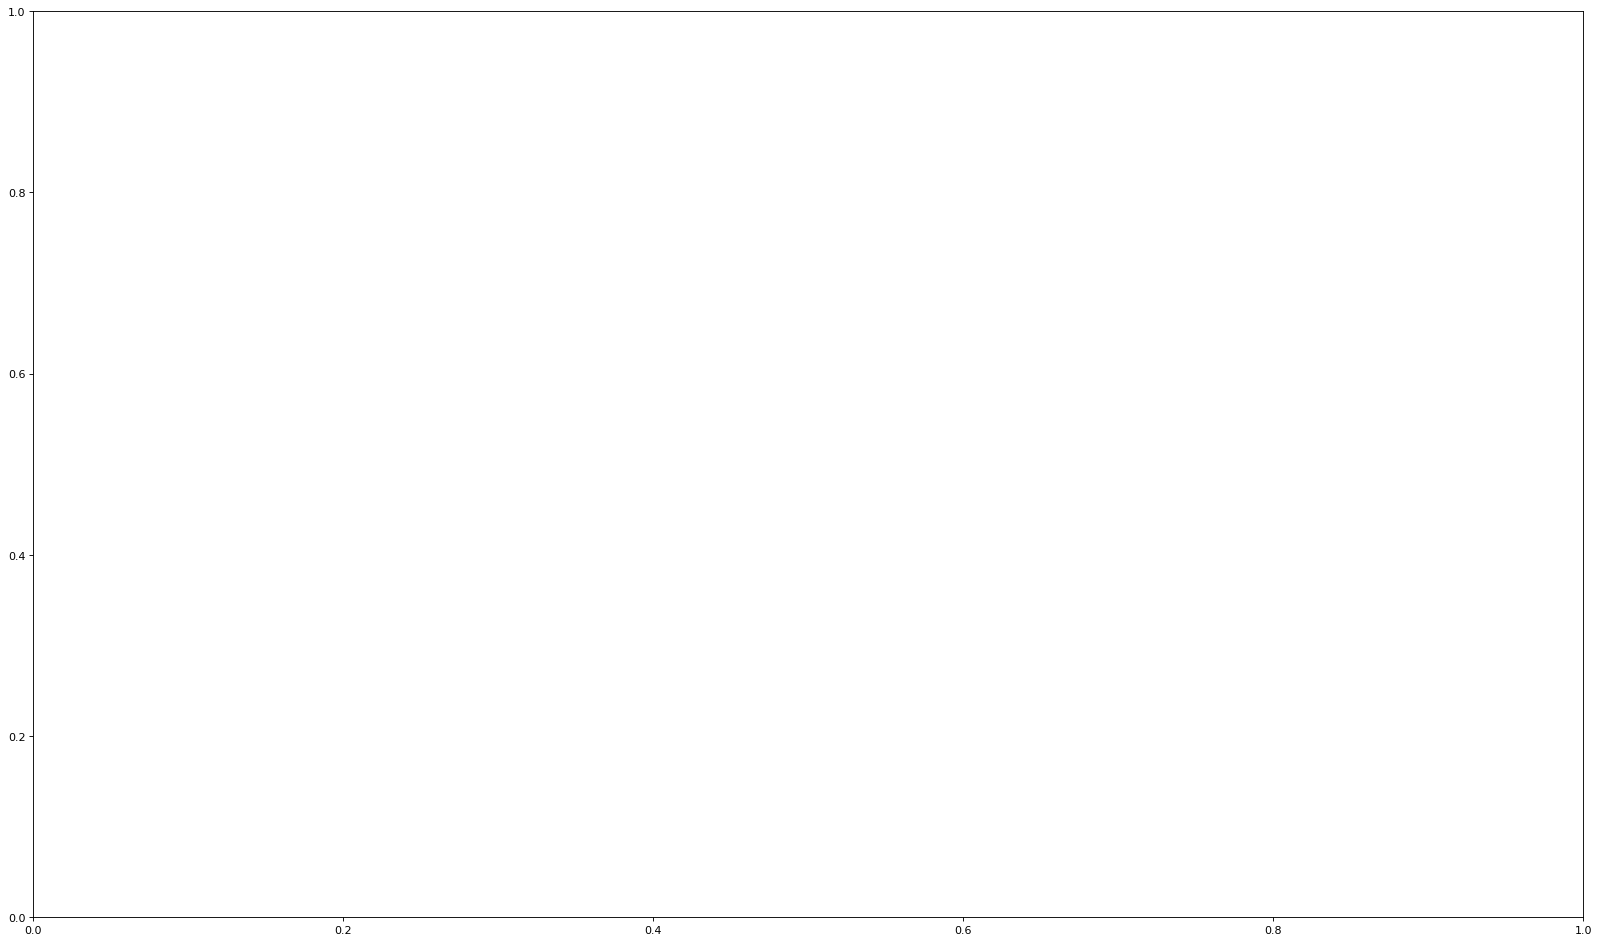

In [96]:
# Visualising the results
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(test_set, color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price, color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction', fontsize=40)

plt.show()

In [ ]:
# Making the predictions
test_set = df_train.values[100000:101000]
inputs = np.reshape(test_set, (len(test_set), 1))

inputs = np.reshape(inputs, (len(test_set), 1, 1))
predicted_BTC_price = regressor.predict(inputs)

In [ ]:
# Visualising the results
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(test_set, color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price, color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction', fontsize=40)

plt.show()

In [ ]:
high = 0.1898
mid = 0.5435
low = 2.437


In [ ]:
high = 6.9
mid = 10
low = 14.8

In [ ]:
#R1
R1 = mid + (mid*(low+high)  - 2*high*low)/(high + low -2*mid)
R1

In [ ]:
#R2
mid + (mid*(low+high)  - 2*high*low)/(high + low -2*mid) - mid

In [ ]:
# R3
R1*(R1 + low - mid)/(low-mid)